In [1]:
import numpy as np
from scipy.stats import gamma, poisson

# Data
y = [2, 3, 7, 8, 4, 5, 10, 15, 8, 6, 3, 11]

# Calculate the mean of the data (MLE for lambda in Poisson distribution)
mean_y = np.mean(y)
variance_y = np.var(y)


## Evaluate the Poisson Model

In [2]:
# Prior parameters for the Gamma distribution
alpha = 2
beta = 1

# Define the prior distribution
prior = gamma(a=alpha, scale=1/beta)

# Sample from the prior distribution
lambda_samples = prior.rvs(size=1000)
mean_lambda = np.mean(lambda_samples)


# Define the Poisson likelihood
likelihood = poisson(mu=np.mean(lambda_samples))

# Print the prior and likelihood
print("Prior distribution (Gamma):", prior)
print("Likelihood (Poisson):", likelihood)

Prior distribution (Gamma): <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000025378D6EDA0>
Likelihood (Poisson): <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025378D6D690>


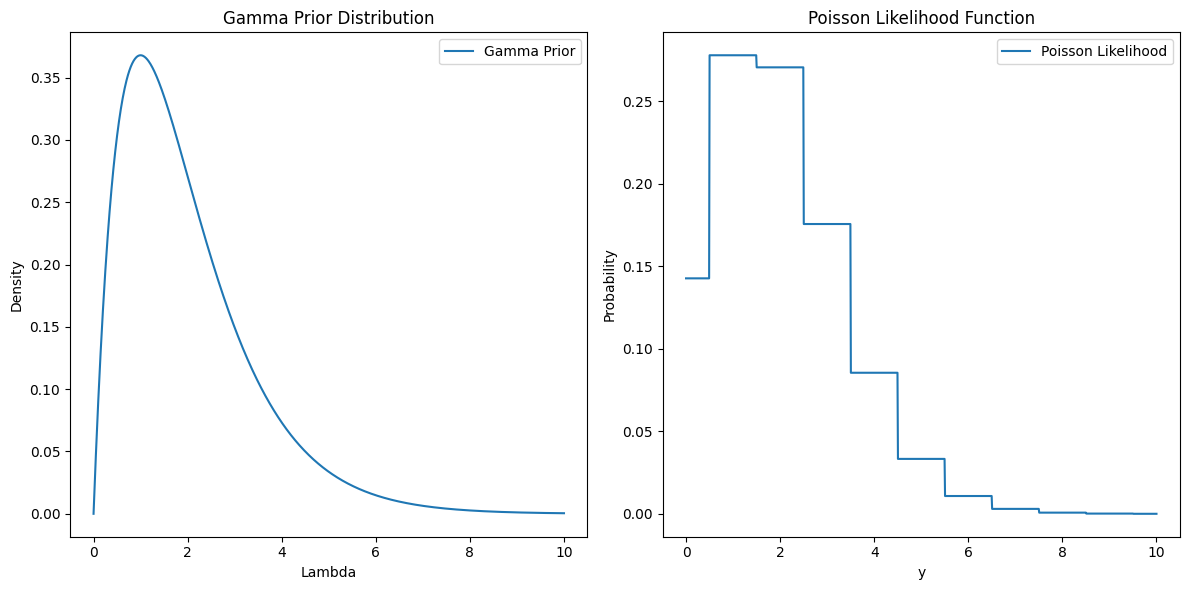

In [3]:
import matplotlib.pyplot as plt

# Plot the Gamma prior distribution
x = np.linspace(0, 10, 1000)
prior_pdf = prior.pdf(x)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x, prior_pdf, label='Gamma Prior')
plt.title('Gamma Prior Distribution')
plt.xlabel('Lambda')
plt.ylabel('Density')
plt.legend()

# Plot the Poisson likelihood function
x = np.linspace(0, 10, 1000)
likelihood_pmf = poisson.pmf(np.round(x), mean_lambda)

plt.subplot(1, 2, 2)
plt.plot(x, likelihood_pmf, label='Poisson Likelihood')
plt.title('Poisson Likelihood Function')
plt.xlabel('y')
plt.ylabel('Probability')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
# Calculate the log-likelihood of the Poisson model
log_likelihood = np.sum(poisson.logpmf(y, mean_y))

# Number of parameters (k) and number of data points (n)
k = 1
n = len(y)

# Calculate BIC
bic = k * np.log(n) - 2 * log_likelihood

print("BIC for the Poisson model:", bic)

BIC for the Poisson model: 69.43128441068727


## Fitting a Negative Binomial

In [5]:
import numpy as np
from scipy.stats import nbinom
from scipy.optimize import minimize

# Define the negative log-likelihood function for the Negative Binomial distribution
def neg_log_likelihood_nb(params, data):
    r, p = params
    return -np.sum(nbinom.logpmf(y, r, p))

# Initial guesses for r and p
initial_params = [1, 0.5]

# Fit the Negative Binomial distribution to the data
model_nb = minimize(neg_log_likelihood_nb, initial_params, args=(y,), bounds=[(1e-5, None), (1e-5, 1-1e-5)])

# Extract the fitted parameters
r_fitted, p_fitted = model_nb.x

# Print the fitted parameters
print(f"Fitted r (number of successes until stop): {r_fitted}")
print(f"Fitted p (probability of success): {p_fitted}")

# Calculate the log-likelihood of the model
log_likelihood_nb = -neg_log_likelihood_nb((r_fitted, p_fitted), y)

# Number of parameters (k) and number of data points (n)
k = 2
n = len(y)

# Calculate BIC
bic = k * np.log(n) - 2 * log_likelihood_nb

print("BIC for the Negative Binomial model:", round(bic,2))

Fitted r (number of successes until stop): 7.093178020551069
Fitted p (probability of success): 0.5093293756130577
BIC for the Negative Binomial model: 68.51


## Fitting a Beta-Binomial

In [6]:
from scipy.special import betaln

# Define the Beta-Binomial PMF
def beta_binomial_pmf(k, n, alpha, beta):
    k = np.asarray(k)  # Ensure k is a numpy array
    return np.exp(betaln(k + alpha, n - k + beta) - betaln(alpha, beta) - betaln(k + 1, n - k + 1))

# Define the negative log-likelihood function for the Beta-Binomial distribution
def neg_log_likelihood_bb(params, data):
    alpha, beta = params
    n = max(data)  # Assuming n is the number of trials in the data
    return -np.sum(np.log(beta_binomial_pmf(data, n, alpha, beta)))

# Initial guesses for alpha and beta
initial_params = [1, 1]

# Fit the Beta-Binomial distribution to the data
model_bb = minimize(neg_log_likelihood_bb, initial_params, args=(y,), bounds=[(1e-5, None), (1e-5, None)])

# Extract the fitted parameters
alpha_fitted, beta_fitted = model_bb.x

# Print the fitted parameters
print(f"Fitted alpha: {alpha_fitted}")
print(f"Fitted beta: {beta_fitted}")

# Calculate the log-likelihood of the model
log_likelihood_bb = -neg_log_likelihood_bb((r_fitted, p_fitted), y)

# Number of parameters (k) and number of data points (n)
k = 2
n = len(y)

# Calculate BIC
bic = k * np.log(n) - 2 * log_likelihood_bb

print("BIC for the Negative Binomial model:", round(bic,2))

Fitted alpha: 1.9383605382246172
Fitted beta: 2.1941417198699704
BIC for the Negative Binomial model: 84.33


## Visualizing the Different Models

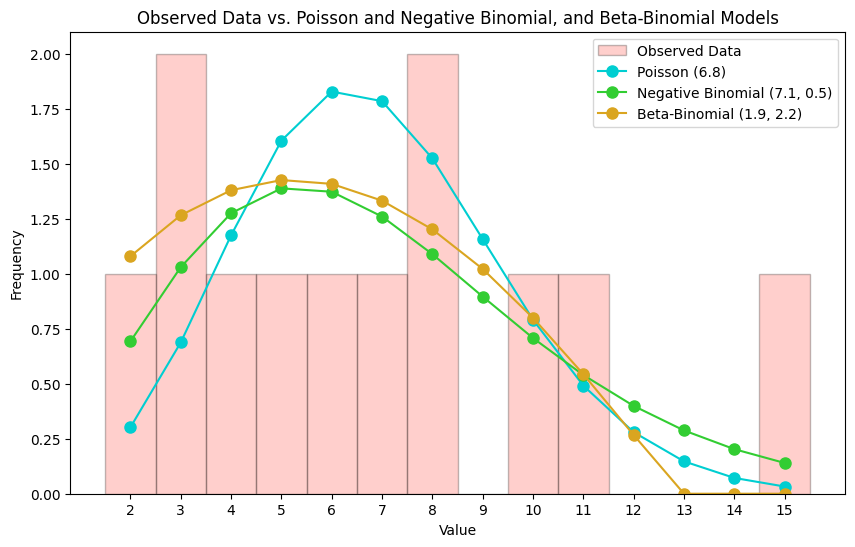

In [14]:
# Plot the observed data as a histogram
plt.figure(figsize=(10, 6))
plt.hist(y, bins=np.arange(min(y)-0.5, max(y) + 1.5), alpha=0.25, color='#FF4136', edgecolor='black', label='Observed Data')
# range(min(y), max(y) + 2)

# Overlay the expected Poisson distribution
x = np.arange(min(y), max(y) + 1)
poisson_pmf = poisson.pmf(x, mean_y) * len(y)  # Scale the PMF by the number of observations
plt.plot(x, poisson_pmf, 'o-', label=f'Poisson ({round(mean_y,1)})', color='#00CED1', markersize=8)

# Calculate the expected Negative Binomial probabilities
x = np.arange(min(y), max(y) + 1)
nbinom_pmf = nbinom.pmf(x, r_fitted, p_fitted) * len(y)  # Scale the PMF by the number of observations

# Overlay the fitted Negative Binomial distribution
plt.plot(x, nbinom_pmf, 'o-', label=f'Negative Binomial ({round(r_fitted,1)}, {round(p_fitted,1)})', color='#32CD32', markersize=8)

# Calculate the expected Beta-Binomial probabilities
x = np.arange(min(y), max(y) + 1)
beta_binom_pmf = beta_binomial_pmf(x, len(y), alpha_fitted, beta_fitted)

# Overlay the fitted Beta-Binomial distribution
plt.plot(x, beta_binom_pmf, 'o-', label=f'Beta-Binomial ({round(alpha_fitted,1)}, {round(beta_fitted,1)})', color='#DAA520', markersize=8)

# Set x-axis labels for every element
plt.xticks(np.arange(min(y), max(y) + 1))

plt.title('Observed Data vs. Poisson and Negative Binomial, and Beta-Binomial Models')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()